# Conditional GAN

기존 GAN의 conditional version으로 간단하게 data y를 추가로 입력하여 학습시킨다.  
논문에서는 CGAN을 mulit-modal model 학습에 사용하는 방법과 image tagging 에 적용한 예제를 제공한다.  

기존의 GAN 은 unconditional 생성모델이라 생성하는 샘플의 종류를 제어 할 수 없었다.  
따라서 정보를 추가하여 데이터 생성을 제어했다.


## Objective

### GAN
$$ \min_{G}\max_{D} V(D,G) = 𝔼_{x\sim p_{data}(x)}[log(D(x))] + 𝔼_{z\sim p_{z}(z)}[log(1-D(G(z)))]$$

### CGAN
$$ \min_{G}\max_{D} V(D,G) = 𝔼_{x\sim p_{data}(x|y)}[log(D(x))] + 𝔼_{z\sim p_{z}(z)}[log(1-D(G(z|y)))]$$

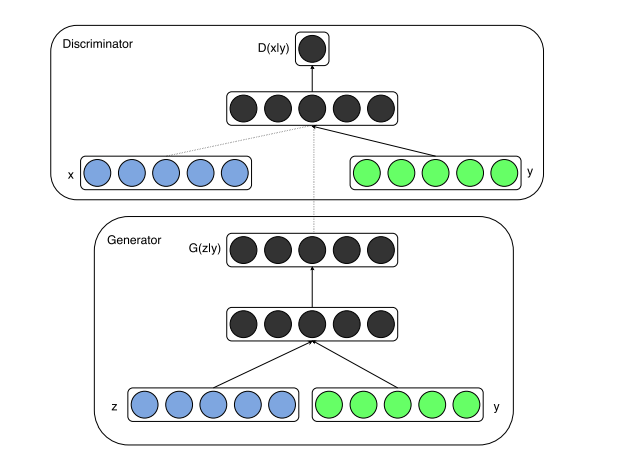

## Experiments

### Unimodal

MNIST image에 대해서 각 클래스를 one-hot encoding하여 CGAN을 학습  
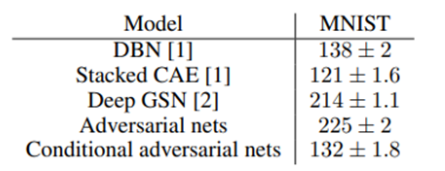

Parzen window based log-likelihood 를 나타낸것 (이미지가 원래이미지와 얼마나 유사한지를 비교, 자금은 사용하지 않음)
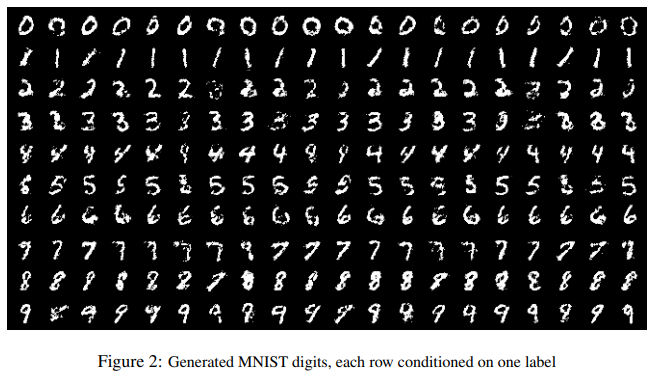

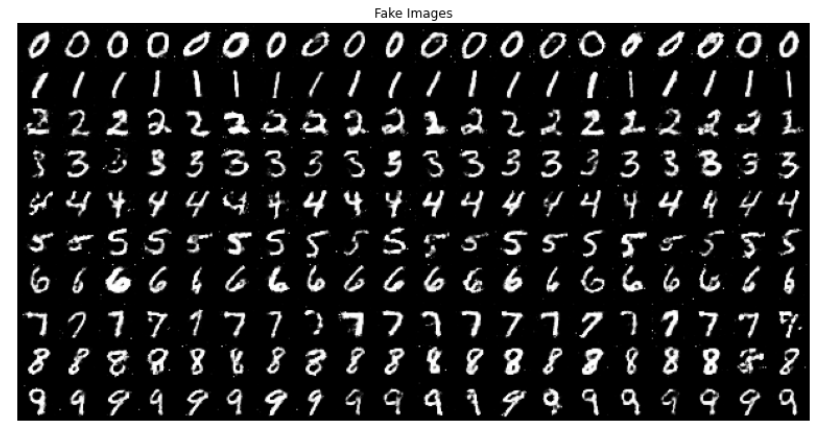

### Multimodal

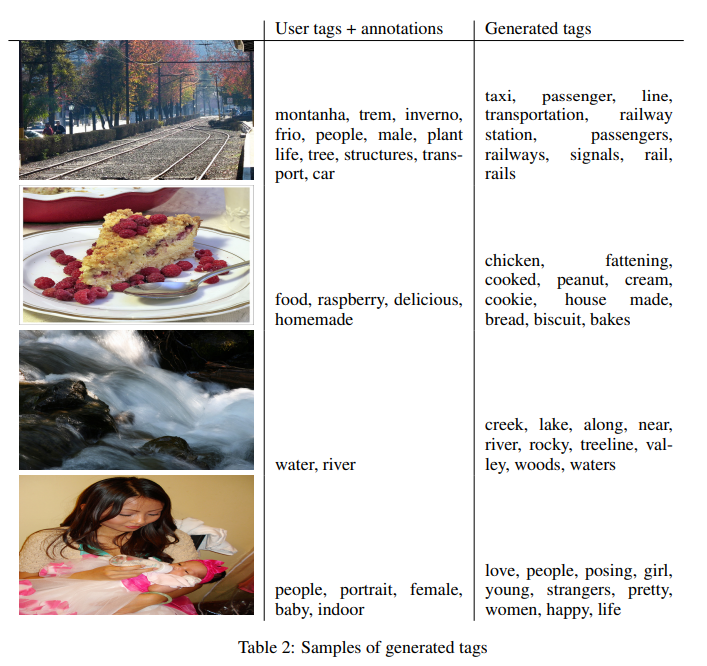

In [ ]:
# 라이브러리
import torch
import torch.nn as nn
import time
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.5],[0.5])])

train_ds = datasets.MNIST('./content/', train=True, transform=train_transform, download=True)
dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./content/MNIST/raw/train-images-idx3-ubyte.gz to ./content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./content/MNIST/raw/train-labels-idx1-ubyte.gz to ./content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./content/MNIST/raw/t10k-images-idx3-ubyte.gz to ./content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./content/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./content/MNIST/raw



In [ ]:
params = {'num_classes':10,
          'nz':100,
          'input_size':(1,28,28)}

class Generator(nn.Module):
  def __init__(self, params):
    super().__init__()
    self.num_classes = params['num_classes'] # 클래스 수, 10
    self.nz = params['nz'] # 노이즈 수, 100
    self.input_size = params['input_size'] # (1,28,28)

    # noise와 label을 결합할 용도인 label embedding matrix를 생성합니다.
    self.label_emb = nn.Embedding(self.num_classes, self.num_classes)

    self.gen = nn.Sequential(
        nn.Linear(self.nz + self.num_classes, 256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(1024, 28*28),
        nn.Tanh()
    )

  def forward(self, z, labels):
    # noise와 label 결합
    gen_input = torch.cat((self.label_emb(labels),z),-1)
    x = self.gen(gen_input)
    x = x.view(x.size(0), *self.input_size)
    return x

class Discriminator(nn.Module):
  def __init__(self,params):
    super().__init__()
    self.input_size = params['input_size']
    self.num_classes = params['num_classes']

    self.label_embedding = nn.Embedding(self.num_classes, self.num_classes)

    self.dis = nn.Sequential(
        nn.Linear(self.num_classes+int(np.prod(self.input_size)),1024),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.2),
        nn.Linear(1024,512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.2),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.2),
        nn.Linear(256,1),
        nn.Sigmoid()
    )

  def forward(self, img, labels):
    # 이미지와 label 결합
    dis_input = torch.cat((img.view(img.size(0),-1),self.label_embedding(labels)),-1)

    x = self.dis(dis_input)
    return x

def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [ ]:
model_gen = Generator(params).to(device)
model_dis = Discriminator(params).to(device)

model_gen.apply(initialize_weights)
model_dis.apply(initialize_weights)

opt_dis = optim.Adam(model_dis.parameters(), lr=1e-4, betas=(0.5,0.999))
opt_gen = optim.Adam(model_gen.parameters(), lr=1e-4, betas=(0.5,0.999))

In [ ]:
nz = params['nz']
num_epochs = 100
loss_history={'gen':[],
              'dis':[]}
loss_func = nn.BCELoss()
batch_count = 0
start_time = time.time()
model_dis.train()
model_gen.train()

for epoch in range(num_epochs):
  for xb, yb in dataloader:
    ba_si = xb.shape[0]

    xb = xb.to(device)
    yb = yb.to(device)
    yb_real = torch.Tensor(ba_si,1).fill_(1.0).to(device) # real_label
    yb_fake = torch.Tensor(ba_si,1).fill_(0.0).to(device) # fake_label

    # Genetator
    model_gen.zero_grad()
    noise = torch.randn(ba_si,100).to(device) # 노이즈 생성
    gen_label = torch.randint(0,10,(ba_si,)).to(device) # label 생성

    # 가짜 이미지 생성
    out_gen = model_gen(noise, gen_label)

    # 가짜 이미지 판별
    out_dis = model_dis(out_gen, gen_label)

    loss_gen = loss_func(out_dis, yb_real)
    loss_gen.backward()
    opt_gen.step()

    # Discriminator
    model_dis.zero_grad()

    # 진짜 이미지 판별
    out_dis = model_dis(xb, yb)
    loss_real = loss_func(out_dis, yb_real)

    # 가짜 이미지 판별
    out_dis = model_dis(out_gen.detach(),gen_label)
    loss_fake = loss_func(out_dis,yb_fake)

    loss_dis = (loss_real + loss_fake) / 2
    loss_dis.backward()
    opt_dis.step()

    loss_history['gen'].append(loss_gen.item())
    loss_history['dis'].append(loss_dis.item())

    batch_count += 1
    if batch_count % 1000 == 0:
        print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))

Epoch: 1, G_Loss: 1.987950, D_Loss: 0.114620, time: 0.28 min
Epoch: 2, G_Loss: 3.145297, D_Loss: 0.042726, time: 0.56 min
Epoch: 3, G_Loss: 3.997711, D_Loss: 0.049139, time: 0.84 min
Epoch: 4, G_Loss: 4.429677, D_Loss: 0.014978, time: 1.12 min
Epoch: 5, G_Loss: 3.804051, D_Loss: 0.087473, time: 1.39 min
Epoch: 6, G_Loss: 3.607552, D_Loss: 0.056071, time: 1.67 min
Epoch: 7, G_Loss: 4.696157, D_Loss: 0.028411, time: 1.95 min
Epoch: 8, G_Loss: 4.647123, D_Loss: 0.185290, time: 2.23 min
Epoch: 9, G_Loss: 4.195268, D_Loss: 0.230088, time: 2.52 min
Epoch: 10, G_Loss: 3.664457, D_Loss: 0.169325, time: 2.85 min
Epoch: 11, G_Loss: 3.286067, D_Loss: 0.099468, time: 3.15 min
Epoch: 12, G_Loss: 2.866605, D_Loss: 0.166593, time: 3.44 min
Epoch: 13, G_Loss: 4.077935, D_Loss: 0.592995, time: 3.72 min
Epoch: 14, G_Loss: 2.307735, D_Loss: 0.322438, time: 4.00 min
Epoch: 15, G_Loss: 1.575786, D_Loss: 0.341604, time: 4.30 min
Epoch: 17, G_Loss: 1.069757, D_Loss: 0.494276, time: 4.59 min
Epoch: 18, G_Loss

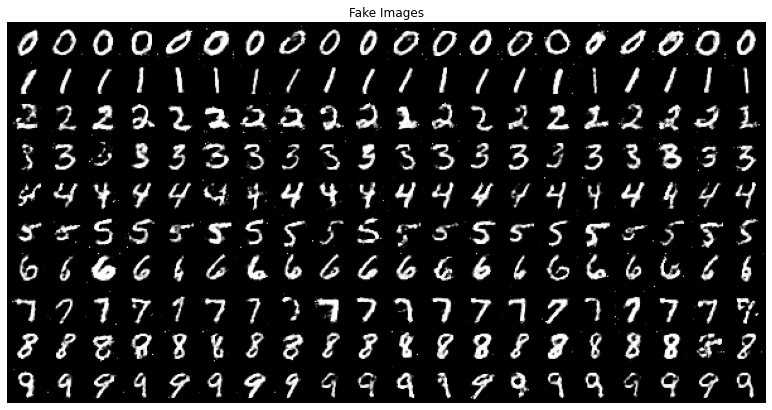

In [ ]:
with torch.no_grad():
    fixed_noise = torch.randn(200, 100, device=device)
    label = torch.IntTensor(np.array([[i]*20 for i in range(10)]).reshape(-1,)).to(device)
    fake = model_gen(fixed_noise, label).detach().cpu()

plt.figure(figsize=(14, 7))
plt.subplot(1,1,1)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True,nrow=20),(1,2,0)))
plt.show()